## NLP: Keyword/Topic Detection

This is a solution to https://platform.stratascratch.com/data-projects/keyword-detection-websites

The challenge is this:

_Your task is to create an algorithm that takes html page as input and infers if the page contains the information about cancer tumorboard or not. What is a tumor board? Tumor Board is a consilium of doctors (usually from different disciplines) discussing cancer cases in their departments. If you want to know more please read this article._

The expected result is a CSV file for test data with columns [doc_id and prediction].

Bonus: if you would like to go the extra mile in this task try to identify tumor board types interdisciplinary, breast, and any third type of tumor board up to you. For these tumor boards please try to identify their schedule: Day (e.g. Friday), frequency (e.g. weekly, bi-weekly, monthly), and time when they start.

_You should prepare a Jupyter Notebook with the code that you used for making the predictions and the following documentation:_

- How did you decide to handle this amount of data?
- How did you decide to do feature engineering?
- How did you decide which models to try (if you decide to train any models)?
- How did you perform validation of your model?
- What metrics did you measure?
- How do you expect your model to perform on test data (in terms of your metrics)?
- How fast will your algorithm performs and how could you improve its performance if you would have more time?
- How do you think you would be able to improve your algorithm if you would have more data?
- What potential issues do you see with your algorithm?



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
train_data = pd.read_csv("datasets/train.csv")
train_data.head()

,url,doc_id,label
0,http://elbe-elster-klinikum.de/fachbereiche/ch...,1,1
1,http://klinikum-bayreuth.de/einrichtungen/zent...,3,3
2,http://klinikum-braunschweig.de/info.php/?id_o...,4,1
3,http://klinikum-braunschweig.de/info.php/?id_o...,5,1
4,http://klinikum-braunschweig.de/zuweiser/tumor...,6,3


In [3]:
test_data = pd.read_csv("datasets/test.csv")
tumour_keyword_data = pd.read_csv("datasets/keyword2tumor_type.csv")

In [4]:
tumour_keyword_data.head()

,keyword,tumor_type
0,senologische,Brust
1,brustzentrum,Brust
2,breast,Brust
3,thorax,Brust
4,thorakale,Brust


In [5]:
print(f"Train data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")
print(f"Tumour keyword shape: {tumour_keyword_data.shape}")

Train data shape: (100, 3)
Test data shape: (48, 2)
Tumour keyword shape: (126, 2)


In [6]:
train_data.groupby(by = 'label').size()

label
1    32
2    59
3     9
dtype: int64

We have 32 documents without a tumour board, 59 where the tumour board is mentioned but we are uncertain about whether it's the main topic, and 9 where we know for sure that it is the main topic. We clearly have a skewed class distribution, which might play a role later in the models we should try out.

### Preprocessing data

In [7]:
def read_html(doc_id):
    with open(file = f'datasets/htmls/{doc_id}.html', mode = 'r', encoding = 'latin1') as f:
        html = f.read()
        return html

In [8]:
train_data['html'] = train_data['doc_id'].apply(read_html)
train_data.sample(n = 5, random_state=42)

,url,doc_id,label,html
83,http://www.sbk-vs.de/de/medizin/leistungen-und...,125,1,"\n\n<!DOCTYPE HTML>\n<html dir=""ltr"" lang=""de_..."
53,http://www.klinikum-esslingen.de/kliniken-und-...,85,2,"<!DOCTYPE html>\n<html xmlns=""http://www.w3.or..."
70,http://www.malteser-kliniken-rhein-ruhr.de/med...,107,2,"<!DOCTYPE html>\n<html lang=""de"">\n<head>\n\n<..."
45,http://www.klilu.de/medizin__pflege/kliniken_u...,73,2,"<!DOCTYPE html>\n<html lang=""de""><head>\n\t<me..."
44,http://www.kk-bochum.de/de/kliniken_zentren_be...,72,1,"<!DOCTYPE html PUBLIC ""-//W3C//DTD HTML 4.01 T..."


We've read the htmls, but we'll have to process them a little to make them readable text that we can work with.

In [9]:
#https://stackoverflow.com/questions/5598524/can-i-remove-script-tags-with-beautifulsoup
#https://www.educative.io/answers/how-to-use-gettext-in-beautiful-soup

import warnings
from bs4 import BeautifulSoup
warnings.filterwarnings(action='ignore')

def extract_text_from_html(html):
    bs = BeautifulSoup(markup=html, features = 'lxml')
    for script in bs(name=['script', 'style']):
        script.decompose()
    return bs.get_text(separator=' ')

train_data['html_text'] = train_data['html'].apply(extract_text_from_html)
train_data.sample(n=5, random_state=42)

,url,doc_id,label,html,html_text
83,http://www.sbk-vs.de/de/medizin/leistungen-und...,125,1,"\n\n<!DOCTYPE HTML>\n<html dir=""ltr"" lang=""de_...",\n \n \n \n \n Prostata-Karzinom-Zentrum - Sch...
53,http://www.klinikum-esslingen.de/kliniken-und-...,85,2,"<!DOCTYPE html>\n<html xmlns=""http://www.w3.or...",\n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \...
70,http://www.malteser-kliniken-rhein-ruhr.de/med...,107,2,"<!DOCTYPE html>\n<html lang=""de"">\n<head>\n\n<...",\n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \...
45,http://www.klilu.de/medizin__pflege/kliniken_u...,73,2,"<!DOCTYPE html>\n<html lang=""de""><head>\n\t<me...",\n \n \n \n Darmzentrum Rheinpfalz » Zentren A...
44,http://www.kk-bochum.de/de/kliniken_zentren_be...,72,1,"<!DOCTYPE html PUBLIC ""-//W3C//DTD HTML 4.01 T...",\n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \...


We finally have the text from the html, but it still has some idiosyncracies left from being an html, like newlines. Let's clear those up. Our model only needs the important words from the text - not the stopwords, punctuations, extra spaces, etc.

In [14]:
from gensim.parsing import preprocessing

def preprocess_html_text(html_text):
    preprocessed_text = preprocessing.strip_non_alphanum(s = html_text)
    preprocessed_text = preprocessing.strip_multiple_whitespaces(s = preprocessed_text)
    preprocessed_text = preprocessing.strip_punctuation(s = preprocessed_text)
    preprocessed_text = preprocessing.strip_numeric(s = preprocessed_text)
    preprocessed_text = preprocessing.stem_text(text = preprocessed_text)
    preprocessed_text = preprocessing.remove_stopwords(s = preprocessed_text)

    return preprocessed_text

In [15]:
train_data['preprocessed_text'] = train_data['html_text'].apply(preprocess_html_text)
train_data.sample(n = 5, random_state = 42)

,url,doc_id,label,html,html_text,preprocessed_text
83,http://www.sbk-vs.de/de/medizin/leistungen-und...,125,1,"\n\n<!DOCTYPE HTML>\n<html dir=""ltr"" lang=""de_...",\n \n \n \n \n Prostata-Karzinom-Zentrum - Sch...,prostata karzinom zentrum schwarzwald baar kli...
53,http://www.klinikum-esslingen.de/kliniken-und-...,85,2,"<!DOCTYPE html>\n<html xmlns=""http://www.w3.or...",\n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \...,unser profil gefã ã und thoraxchirurgi kliniku...
70,http://www.malteser-kliniken-rhein-ruhr.de/med...,107,2,"<!DOCTYPE html>\n<html lang=""de"">\n<head>\n\n<...",\n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \...,maltes kliniken rhein ruhr darmzentrum duisbur...
45,http://www.klilu.de/medizin__pflege/kliniken_u...,73,2,"<!DOCTYPE html>\n<html lang=""de""><head>\n\t<me...",\n \n \n \n Darmzentrum Rheinpfalz » Zentren A...,darmzentrum rheinpfalz zentren z kliniken und ...
44,http://www.kk-bochum.de/de/kliniken_zentren_be...,72,1,"<!DOCTYPE html PUBLIC ""-//W3C//DTD HTML 4.01 T...",\n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \...,mund kiefer und plastisch gesichtschirurgi en ...


We finally have clean text that we can work with.

### Exploratory Data Analysis

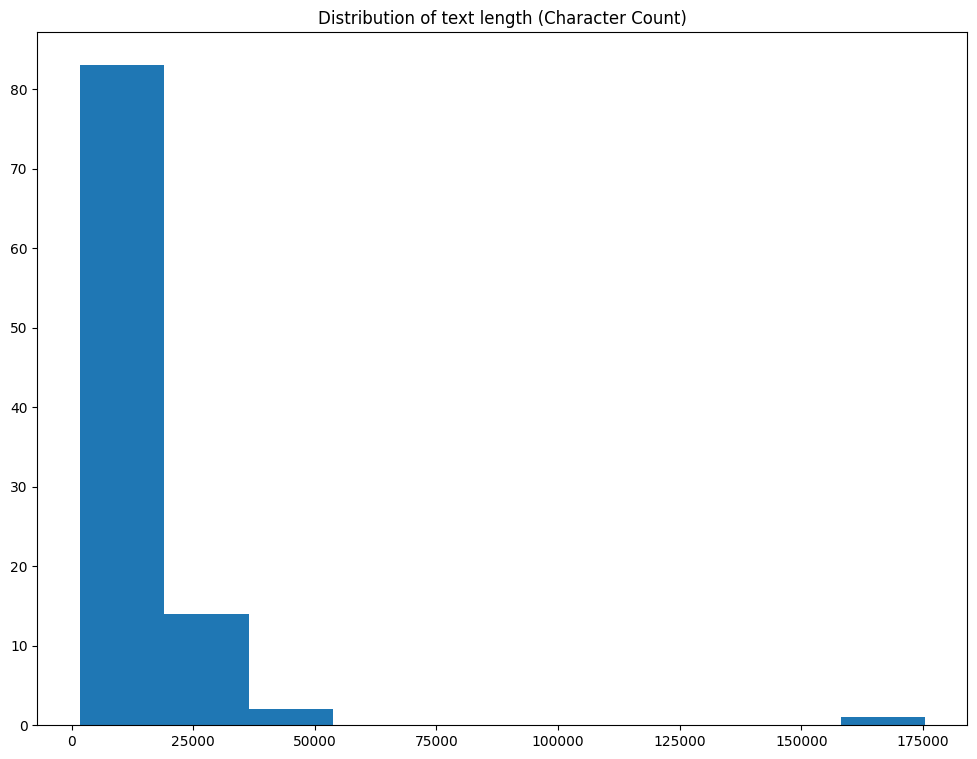

In [16]:
plt.figure(figsize=(12,9))
plt.hist(x = train_data['preprocessed_text'].apply(len))
plt.title('Distribution of text length (Character Count)')
plt.show()

There's one document with ~170k character count, the rest are all ~<50k. Let's check how this translates into word count.

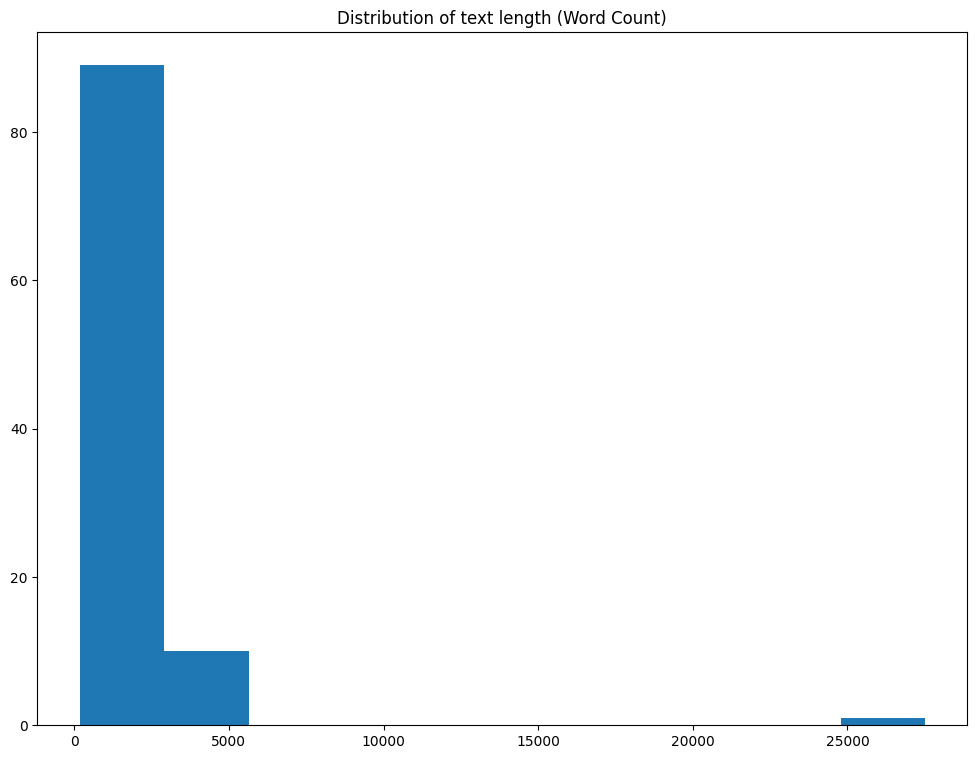

In [17]:
plt.figure(figsize=(12,9))
plt.hist(x = train_data['preprocessed_text'].apply(lambda text: text.split(' ')).apply(len))
plt.title('Distribution of text length (Word Count)')
plt.show()

Sure enough, the one larger document is >25k words, while the rest seem to be <5k.

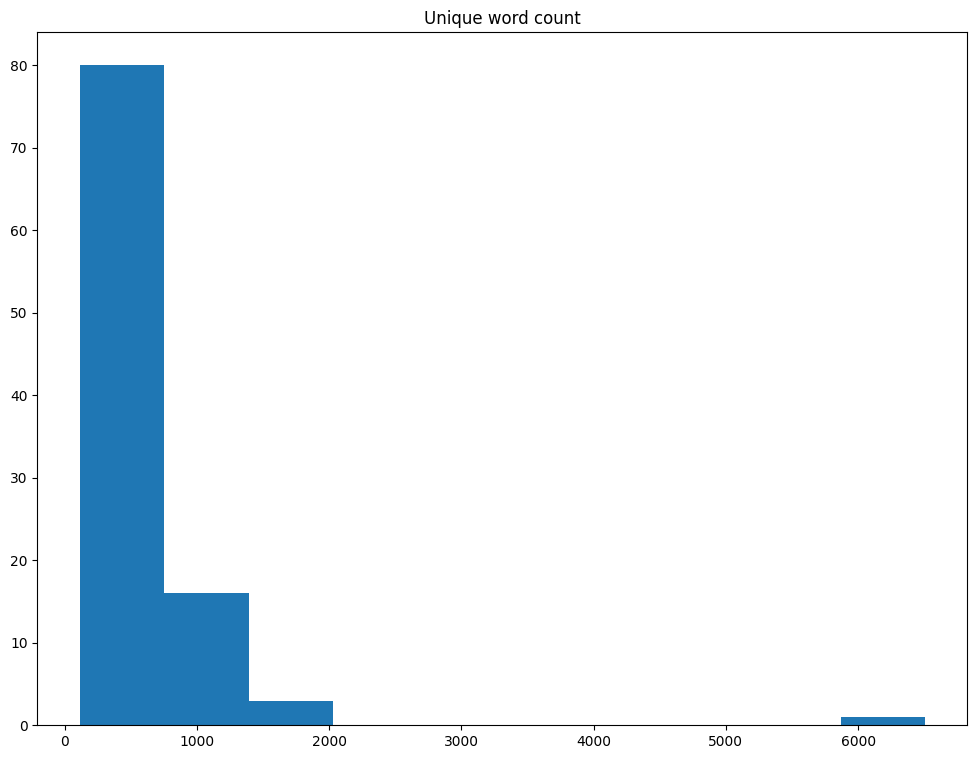

In [18]:
plt.figure(figsize=(12,9))
plt.hist(x = train_data['preprocessed_text'].apply(lambda text: set(text.split(' '))).apply(len))
plt.title('Unique word count')
plt.show()

Most documents are <2k original words. All of this information might be useful in modeling a vocabulary later down the line.

### Modeling

To solve our task at hand, which is an NLP task, we'll first check out Siamese Nets, which are usually used for few shots learning tasks - which is useful here, since we have class imbalance and a small dataset. We'll see later whether a more sophisticated model like a Transformer is useful in our case.

In [19]:
import random
import tensorflow as tf

np.random.seed(42)
tf.random.set_seed(42)

2024-01-29 21:57:07.870906: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-29 21:57:12.501182: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-29 21:57:13.779699: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-01-29 21:57:13.779733: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

### Data Generators

Since we have a lot of documents, loading them all at once into the memory is not a good idea. Data Generators are useful here - they batch data and allow our model to read the data from disk in batches. This serves the purpose of not overwhelming the memory as well as allows parallelisation in cases where the hardware is capable of it and we use parallelised code.

In [27]:
class Pairs(tf.keras.utils.Sequence):
    def __init__(self, dataframe: pd.DataFrame, labels: pd.Series, n_batch: int, batch_size: int):
        self.dataframe = dataframe
        self.labels = labels
        self.n_batch = n_batch
        self.batch_size = batch_size

        self.all_classes = set(self.labels)
        self.anchor_groups = {}
        for target_class in self.all_classes:
            self.anchor_groups[target_class] = {
                'positive': self.dataframe[self.labels == target_class],
                'negative': self.dataframe[self.labels != target_class]
            }

    def __len__(self):
        return self.n_batch
    
    def __getitem__(self, item):
        pairs = []

        for i in range(int(self.batch_size / 2)):
            anchor_class = random.randint(1,3)
            anchor_group = self.anchor_groups[anchor_class]['positive']
            not_anchor_group = self.anchor_groups[anchor_class]['negative']

            anchor = anchor_group.sample(n = 1).iloc[0]
            positive = anchor_group.sample(n = 1).iloc[0]
            negative = not_anchor_group.sample(n = 1).iloc[0]
            
            pairs.append([anchor, positive, 1])
            pairs.append([anchor, negative, 0])

        random.shuffle(x = pairs)
        pairs = np.array(pairs)

        data_pairs = pairs[:, :2]
        targets = pairs[:, 2]

        return data_pairs, tf.convert_to_tensor(targets, dtype = np.float32)
    

    def get_support_set(self, sample_size: int = 1):
        support_set = {}
        for target_class in self.all_classes:
            support_set[target_class] = self.anchor_groups[target_class]['positive'].sample(n = sample_size)

        return support_set

This is a majority of the tedious work with this network - we're making sure the sampling done by the data generators is random and balanced for classes.

### Model Definition

The model will be a sequence of layers, starting with a [TextVectorization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization) layer. This layer vectorises the text so that we get an integer sequence. At training time, we have to provide it with a vocabulary that it'll also use to map text to integer sequences during prediction time.

Following this vectorization layer, we'll have interspersed [Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense), [Dropout](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout), and [L2 normalization](https://www.tensorflow.org/api_docs/python/tf/math/l2_normalize) layers. A good point start is 3 dense layers with the dropout layers between them, followed by the normalization layer.

In [21]:
#https://pyimagesearch.com/2020/11/30/siamese-networks-with-keras-tensorflow-and-deep-learning/
class SiameseNetwork(tf.keras.Model):
    def __init__(self, corpora: pd.Series):
        super(SiameseNetwork, self).__init__()
        self.vectorizer_layer: tf.keras.layers.TextVectorization = tf.keras.layers.TextVectorization(
            #vocabulary from EDA
            max_tokens = 2000,
            output_mode = 'int',
            output_sequence_length = 512
        )
        self.vectorizer_layer.adapt(corpora.values)

        self.encoder = tf.keras.Sequential(layers = [
            self.vectorizer_layer,
            tf.keras.layers.Dense(units = 256, activation=tf.keras.activations.relu),
            tf.keras.layers.Dropout(rate = 0.3),
            tf.keras.layers.Dense(units = 128, activation=tf.keras.activations.relu),
            tf.keras.layers.Dropout(rate = 0.3),
            tf.keras.layers.Dense(units = 64, activation=tf.keras.activations.relu),
            tf.keras.layers.Lambda(function = lambda x: tf.math.l2_normalize(x, axis = 1))
        ])
        self.encoding_distance = tf.keras.layers.Dot(axes=1)

    def __call__(self, inputs, *args, **kwargs):
        anchors, supports = inputs[:, 0], inputs[:, 1]
        anchors_encoded = self.encoder(anchors)
        supports_encoded = self.encoder(supports)
        return self.encoding_distance((anchors_encoded, supports_encoded))

    def predict_with_support_set(self, entry, support_set: dict):
        scores = {}
        for instance_class, texts in support_set.items():
            class_scores = ([self(np.array([entry, text]).reshape((-1, 2))) for text in texts])
            scores[instance_class] = tf.math.reduce_mean(class_scores)

        return max(scores, key = scores.get)

### Model Instantiation and Training

In [22]:
model = SiameseNetwork(corpora=train_data['preprocessed_text'])
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = 'binary_accuracy')

2024-01-29 22:40:15.847243: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-01-29 22:40:15.847317: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (kevinvegda1): /proc/driver/nvidia/version does not exist
2024-01-29 22:40:15.854362: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


We have our model ready to train. Let's put some data aside for validation and train the model.

In [23]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(train_data['preprocessed_text'], train_data['label'], test_size=0.2, random_state=42, stratify=train_data['label'])

In [28]:
#training params
BATCH_SIZE = 64
N_BATCH = 100
#instantiate the training and validation data/pair generators
TRAIN_PAIR_GENERATOR = Pairs(dataframe=X_train,labels=y_train,n_batch=N_BATCH,batch_size=BATCH_SIZE)
VAL_PAIR_GENERATOR = Pairs(dataframe=X_val, labels=y_val, n_batch=N_BATCH,batch_size=BATCH_SIZE)

Finally, let's decide an early stopping criteria so our training doesn't go on unnecessarily.

In [25]:
#https://keras.io/api/callbacks/early_stopping/
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [29]:
history = model.fit(x = TRAIN_PAIR_GENERATOR, validation_data= VAL_PAIR_GENERATOR, epochs = 10, callbacks=[early_stopping_callback], verbose=1)

Epoch 1/10
100/100 [==============================] - 17s 162ms/step - loss: 0.1746 - binary_accuracy: 0.9166 - val_loss: 0.9304 - val_binary_accuracy: 0.5719
Epoch 2/10
100/100 [==============================] - 16s 158ms/step - loss: 0.0285 - binary_accuracy: 0.9842 - val_loss: 0.9534 - val_binary_accuracy: 0.5547
Epoch 3/10
100/100 [==============================] - 16s 162ms/step - loss: 0.0287 - binary_accuracy: 0.9853 - val_loss: 0.9768 - val_binary_accuracy: 0.5641
Epoch 4/10
100/100 [==============================] - 16s 155ms/step - loss: 0.0270 - binary_accuracy: 0.9856 - val_loss: 1.0011 - val_binary_accuracy: 0.5658


In [32]:
history.history['binary_accuracy']

[0.9165624976158142,
 0.9842187762260437,
 0.9853125214576721,
 0.9856250286102295]

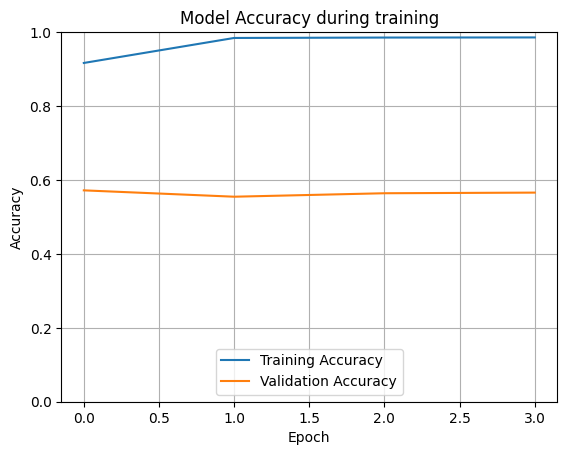

In [43]:
fig, ax = plt.subplots()
ax.plot(range(len(history.history['binary_accuracy'])), history.history['binary_accuracy'], label = 'Training Accuracy')
ax.plot(range(len(history.history['val_binary_accuracy'])), history.history['val_binary_accuracy'], label = 'Validation Accuracy')
ax.set_title('Model Accuracy during training')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.set_ylim(0,1)
ax.legend(loc = 'lower center')
ax.grid()
plt.show()

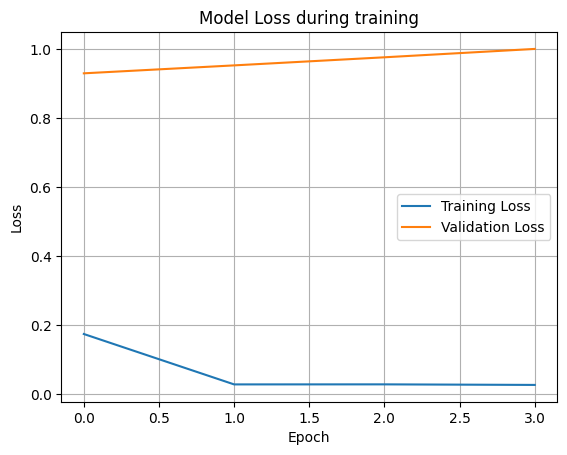

In [46]:
fig, ax = plt.subplots()
ax.plot(range(len(history.history['loss'])), history.history['loss'], label = 'Training Loss')
ax.plot(range(len(history.history['val_loss'])), history.history['val_loss'], label = 'Validation Loss')
ax.set_title('Model Loss during training')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()
ax.grid()
plt.show()

Let's try to make predictions on the validation set. We'd expect the model in production to perform a little (though not a lot) worse than the validation metrics.

In [47]:
y_pred = X_val.apply(lambda text: model.predict_with_support_set(
    entry = text,
    support_set = TRAIN_PAIR_GENERATOR.get_support_set(7)
))

In [48]:
from sklearn.metrics import classification_report

report = classification_report(y_val, y_pred, zero_division=0)
print(report)

              precision    recall  f1-score   support

           1       0.60      0.50      0.55         6
           2       0.73      0.92      0.81        12
           3       0.00      0.00      0.00         2

    accuracy                           0.70        20
   macro avg       0.44      0.47      0.45        20
weighted avg       0.62      0.70      0.65        20



An accuracy of 0.7 is not bad for our first model. Let's make some predictions on the test data.

In [49]:
#we need to preprocess the test data the same way we did the training data
test_data['html'] = test_data['doc_id'].apply(read_html)
test_data['html_text'] = test_data['html'].apply(extract_text_from_html)
test_data['preprocessed_text'] = test_data['html_text'].apply(preprocess_html_text)
test_data.sample(n = 5, random_state=42)

,url,doc_id,html,html_text,preprocessed_text
27,http://www.josephstift-dresden.de/pressemittei...,71,"<?xml version=""1.0"" encoding=""utf-8""?>\n<rss v...",\n \n Krankenhaus St. Joseph-Stift Dresden (PM...,krankenhau st joseph stift dresden pm http www...
40,http://www.pius-hospital.de/kliniken/gynaekolo...,123,"<!DOCTYPE html>\n<html lang=""de"" dir=""ltr"" pre...",\n \n \n \n \n \n \n \n \n \n \n Patienteninfo...,patienteninformationen klinik fã¼r frauenheilk...
26,http://www.interdisziplinaere-endoskopie.mri.t...,70,"<!DOCTYPE html>\n<html lang=""de"">\n\t<!--[if I...",\n \n \n \n \n \n \n Herzlich Willkommen â...,herzlich willkommen â interdisziplinã endoskop...
43,http://www.uk-augsburg.de/krebsbehandlung/diag...,134,"<!DOCTYPE html> \n<html lang=""de""> \n\t<head> ...",\n \n \n \n \n \n \n \n \n \n \n \n \n \n \n Z...,zweitmeinung â warum ein weiter einschã tzung ...
24,http://www.hjk-muenster.de/unsere-kompetenzen/...,68,"<!DOCTYPE html><html lang=""de"" class=""no-js""><...",Gelenkersatz Skip to main content hjk Die Ei...,gelenkersatz skip main content hjk die einrich...


### Inference

In [50]:
test_data['prediction'] = test_data['preprocessed_text'].apply(lambda text: model.predict_with_support_set(
    entry = text,
    support_set = TRAIN_PAIR_GENERATOR.get_support_set(sample_size=7)
))
test_data.sample(n = 5, random_state=42)

,url,doc_id,html,html_text,preprocessed_text,prediction
27,http://www.josephstift-dresden.de/pressemittei...,71,"<?xml version=""1.0"" encoding=""utf-8""?>\n<rss v...",\n \n Krankenhaus St. Joseph-Stift Dresden (PM...,krankenhau st joseph stift dresden pm http www...,2
40,http://www.pius-hospital.de/kliniken/gynaekolo...,123,"<!DOCTYPE html>\n<html lang=""de"" dir=""ltr"" pre...",\n \n \n \n \n \n \n \n \n \n \n Patienteninfo...,patienteninformationen klinik fã¼r frauenheilk...,1
26,http://www.interdisziplinaere-endoskopie.mri.t...,70,"<!DOCTYPE html>\n<html lang=""de"">\n\t<!--[if I...",\n \n \n \n \n \n \n Herzlich Willkommen â...,herzlich willkommen â interdisziplinã endoskop...,1
43,http://www.uk-augsburg.de/krebsbehandlung/diag...,134,"<!DOCTYPE html> \n<html lang=""de""> \n\t<head> ...",\n \n \n \n \n \n \n \n \n \n \n \n \n \n \n Z...,zweitmeinung â warum ein weiter einschã tzung ...,2
24,http://www.hjk-muenster.de/unsere-kompetenzen/...,68,"<!DOCTYPE html><html lang=""de"" class=""no-js""><...",Gelenkersatz Skip to main content hjk Die Ei...,gelenkersatz skip main content hjk die einrich...,2


In [51]:
test_data['prediction'].value_counts()

prediction
2    38
1     9
3     1
Name: count, dtype: int64

In [52]:
test_data[['doc_id', 'prediction']]

,doc_id,prediction
0,0,2
1,2,2
2,7,2
3,15,2
4,16,2
5,24,2
6,31,2
7,32,2
8,36,1
9,38,2
